In [111]:
import gym
env = gym.make('CartPole-v0')

import autograd.numpy as np
import autograd

%matplotlib inline
import matplotlib.pyplot as plt

import pdb #pdb.set_trace()

[2016-06-29 22:50:38,764] Making new env: CartPole-v0


In [153]:
def Softmax(x):
    return np.exp(x)/np.sum(np.exp(x))

def relu(x):
    x[x<0] = 0
    return x

class Net():
    """
    A 2 layer feed forward neural network.
    """
    def __init__(self,mid=10):
        self.W1 = np.random.standard_normal((4,mid))
        self.W2 = np.random.standard_normal((mid,2))
        self.b1 = np.random.standard_normal((1,mid))
        self.b2 =np.random.standard_normal((1,2))
        
    def __call__(self,x):
        return Softmax(np.dot(relu(np.dot(x,self.W1)+self.b1),self.W2) + self.b2)
    
if __name__ =='__main__':
    N = Net()
    print(N(np.random.random((1,4))))

[[  4.18872359e-04   9.99581128e-01]]


In [154]:
def Run(Controller,T=200):
    """
    Run the cart simulation using a given controller.
    Controller outputs a distribution on actions.
    """
    #inits
    done = False
    obs = np.zeros((4,T))
    prob_actions = np.zeros((T,2))
    actions = np.zeros(T)
    reward = np.zeros(T)
    
    #observation = x, x_dot, theta, theta_dot
    obs[:,0] = env.reset()
    
    #for each time step in the simulation
    for t in range(T-1):
        
        #use the observation to inform a decision
        prob_actions[t,:] = Controller(obs[:,t]).squeeze()
        
        #sample from distribution. choose an action
        #why do we sample? could we not just round?
        actions[t] = np.random.choice([1,0],p=prob_actions[t,:]) #1,0 = left/right, -1 is no action 
        
        #Apply the chosen action
        obs[:,t+1], reward[t], done, info = env.step(actions[t])

        if done:
            break
            
    return reward, obs, actions

if __name__ =='__main__':
    reward,obs,act = Run(Net())
    print(np.sum(reward))
    print(obs.shape)

9.0
(4, 200)


In [155]:
def batch(Controller,batch_size = 50):
    #make a batch -- is there another way to do this? avoiding batches?
    #inits
    batch_Rewards = np.zeros((batch_size,200)) #max sequence length = 200(?)
    batch_Actions = np.zeros((batch_size,200))
    batch_Obs = np.zeros((batch_size,4,200))
    
    for j in range(batch_size):

        #this is important
        #we are given the rewards by some oracle
        #we do not know how they were calculated (but could be learn?)
        R, obs, act = Run(Controller) 

        #
        batch_Rewards[j,0:R.size] = R 
        batch_Actions[j,0:R.size] = act
        batch_Obs[j,:,0:R.size] = obs
    return batch_Rewards,batch_Actions,batch_Obs

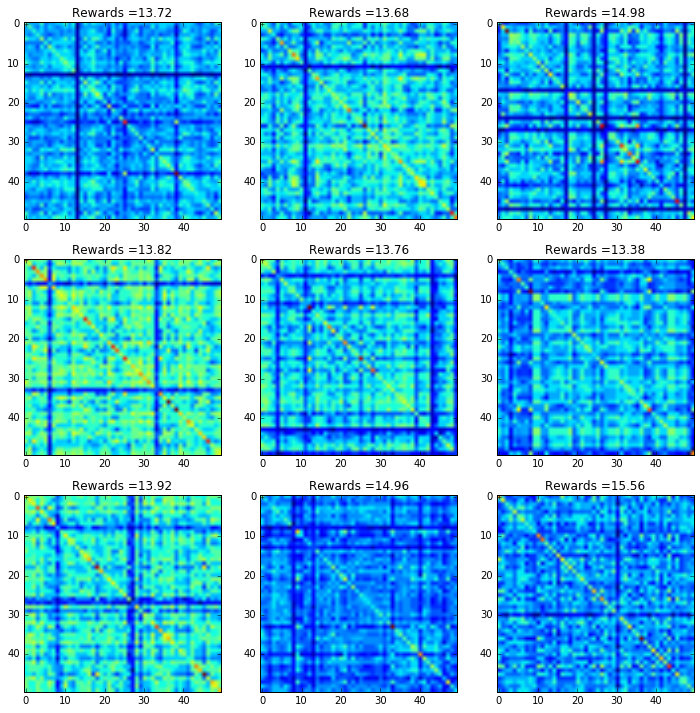

In [173]:
def do(Controller,iters = 9,learning_rate = 0.5):
    plt.figure(figsize=(12,12))
    for i in range(iters):
        batch_Rewards,batch_Actions,batch_Obs = batch(Controller,batch_size = 50)
        Rewards = np.sum(batch_Rewards,axis=1).reshape((50,1)) #batch_size x 1
        
        
        # in this case we can see how rewards correlate with actions
        # however, in practice this would not be feasible (??)
        covar = np.cov((Rewards+batch_Actions)) #+ not * ...
        
        plt.subplot(3,3,i+1)
        plt.imshow(covar)
        plt.title('Rewards ='+str(np.mean(Rewards)))
             
if __name__ =='__main__':      
    do(Net())

In [ ]:
def train(Controller,iters = 20,learning_rate = 0.5):
    plt.figure(figsize=(12,12))
    for i in range(iters):
        batch_Rewards,batch_Actions,batch_Obs = batch(Controller,batch_size = 50)
        Rewards = np.sum(batch_Rewards,axis=1).reshape((50,1)) #batch_size x 1
        
        ###how should we choose which actions to train on?
        # pick upper quartile/???, and update with them
        # reinforce upper half, punish lower half?
        # pick over a certain threshold?
        # pick stochastically, but distribution weighted by reward
        
        

        
        # why not train on all? but we just train negatively on some?
        
        #dLdW1 = 
        
        #ahh, need to backprop some of these
#         Controller.W1 -= learning_rate*dLdW1
#         Controller.W2 -= learning_rate*dLdW2
#         Controller.b1 -= learning_rate*dLdb1
#         Controller.b2 -= learning_rate*dLdb2
        
        print('\rReward = {}'.format(np.mean(Rewards)),end='')
        
        
if __name__ =='__main__':      
    train(Net())

So, just a simple set up. Cart env with random init of 2 layer NN (untrained). What is the covariance of the actions (maybe we can use this to help learn). Each image is a batch.

<img src="_Images/CartActionCovar.png">
<img src="_Images/MoreCartActionCovar.png">

Oh... it should be per batch... not for each ... ?

<img src="_Images/CartActionCovarBatch1.png">
<img src="_Images/CartActionCovarBatch2.png">
<img src="_Images/CartActionCovarBatch3.png">